In [1]:
import os
import torch
import pandas as pd
from torchvision import datasets, models, transforms
import torch.nn as nn
from tqdm.notebook import tqdm

In [2]:
device = "cuda:1"

In [60]:
weight = torch.load("../model/weights/crawl/[thumbnailDataset_test_resize]_ckpt_multiclass_finetune_batch_16_n_epochs_50_lr_1e-05_step_size_7_seed_0.pt")

In [61]:
def resnet50(device='cpu'):
    model_ft = models.resnet50(pretrained=True, progress=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 15)
    model_ft = model_ft.to(device)
    return model_ft

In [62]:
model = resnet50()
model.load_state_dict(weight)

<All keys matched successfully>

In [63]:
embedding_extractor = nn.Sequential(*list(model.children())[:-1])

In [64]:
df = pd.read_csv("../../thumbnailDataset_test_resize.csv", index_col=0)

In [65]:
root = "../../../"

In [66]:
from PIL import Image

def pil_loader(path: str):
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

In [67]:
data_transform = transforms.Compose([
        # transforms.RandomResizedCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [68]:
embedding_extractor = embedding_extractor.to(device)

In [69]:
embs = []
labels = []
fnames = []
for idx in tqdm(range(len(df))):
    item = df.iloc[idx]
    label = item[item == 1].index[0]
    img = pil_loader(os.path.join(root, item['folder'], item.name))
    tensor = data_transform(img).to(device)
    labels.append(label)
    fnames.append(item.name)
    with torch.no_grad():
        emb = embedding_extractor(tensor.unsqueeze(0)).squeeze(0).squeeze(-1).squeeze(-1)
    embs.append(emb.detach().cpu().numpy())

  0%|          | 0/5986 [00:00<?, ?it/s]

In [84]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
norm = scaler.fit_transform(np.stack(embs))

In [86]:
from sklearn.manifold import TSNE
import umap
import numpy as np
m_umap_model = umap.UMAP(n_neighbors=100,
          min_dist=0.5,
          metric='cosine',
          verbose=1,
          n_jobs=8).fit_transform(embs)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.5, n_jobs=8, n_neighbors=100, verbose=1)
Thu Mar 10 08:46:05 2022 Construct fuzzy simplicial set
Thu Mar 10 08:46:05 2022 Finding Nearest Neighbors
Thu Mar 10 08:46:05 2022 Building RP forest with 9 trees
Thu Mar 10 08:46:06 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Thu Mar 10 08:46:11 2022 Finished Nearest Neighbor Search
Thu Mar 10 08:46:11 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Mar 10 08:46:21 2022 Finished embedding


In [87]:
m_umap_model.shape

(5986, 2)

In [105]:
EMOTION_TO_COLOR = {
    'relax':"darkkhaki",
    'chill':"darkkhaki",
    'night':"darkkhaki",
    "sleep":"darkkhaki",
    'sad':"darkkhaki",
    'work':"darkred",
    'car':"blue",
    
    'happy':"sienna",
    'summer':"sienna",
    'dance':"sienna",
    'club':"sienna",
    'party':"sienna",
    'running':"sienna",
    
    'gym':"sienna",
    "workout": "sienna"
    }

In [106]:
df_viz = pd.DataFrame(index=fnames)
df_viz['x'] = m_umap_model[:,0]
df_viz['y'] = m_umap_model[:,1]
df_viz['label'] = labels

In [107]:
df_viz

,x,y,label
0184.jpg,7.680119,4.238794,car
0017.jpg,2.723361,-1.509116,car
0043.jpg,3.593509,-1.705641,car
0161.jpg,3.893300,-0.557709,car
0046.jpg,6.922874,3.078526,car
...,...,...,...
3790166993_84c66178f1_h.jpg,2.107640,1.211015,workout
3655850734_c47b835835_c.jpg,4.601820,0.765768,workout
133391619_6cd43a6489_h.jpg,1.111269,1.382173,workout
3188631158_a737d26b55_h.jpg,1.135616,2.759320,workout


In [114]:
import matplotlib.pyplot as plt


def _get_xy(df, label, c):
    items = df[df['label'] == label]
    print(label, len(items))
    x = df.loc[items.index]['x'].to_numpy()
    y = df.loc[items.index]['y'].to_numpy()
    plt.scatter(x, y, marker="o", color=c, alpha=0.1, s=30, linewidths=1, label=label)

def speech_viz(df):
    plt.figure(figsize=(16,16), dpi=150)
    start_alpha = 0.2
    for idx, label in enumerate(list(set(df['label']))):
        _get_xy(df, label, EMOTION_TO_COLOR[label])
    plt.legend(scatterpoints=1)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.tight_layout()
    plt.show()

running 400
chill 400
party 401
sleep 400
dance 400
sad 400
gym 400
relax 400
club 400
work 400
summer 400
workout 385
happy 400
night 400
car 400


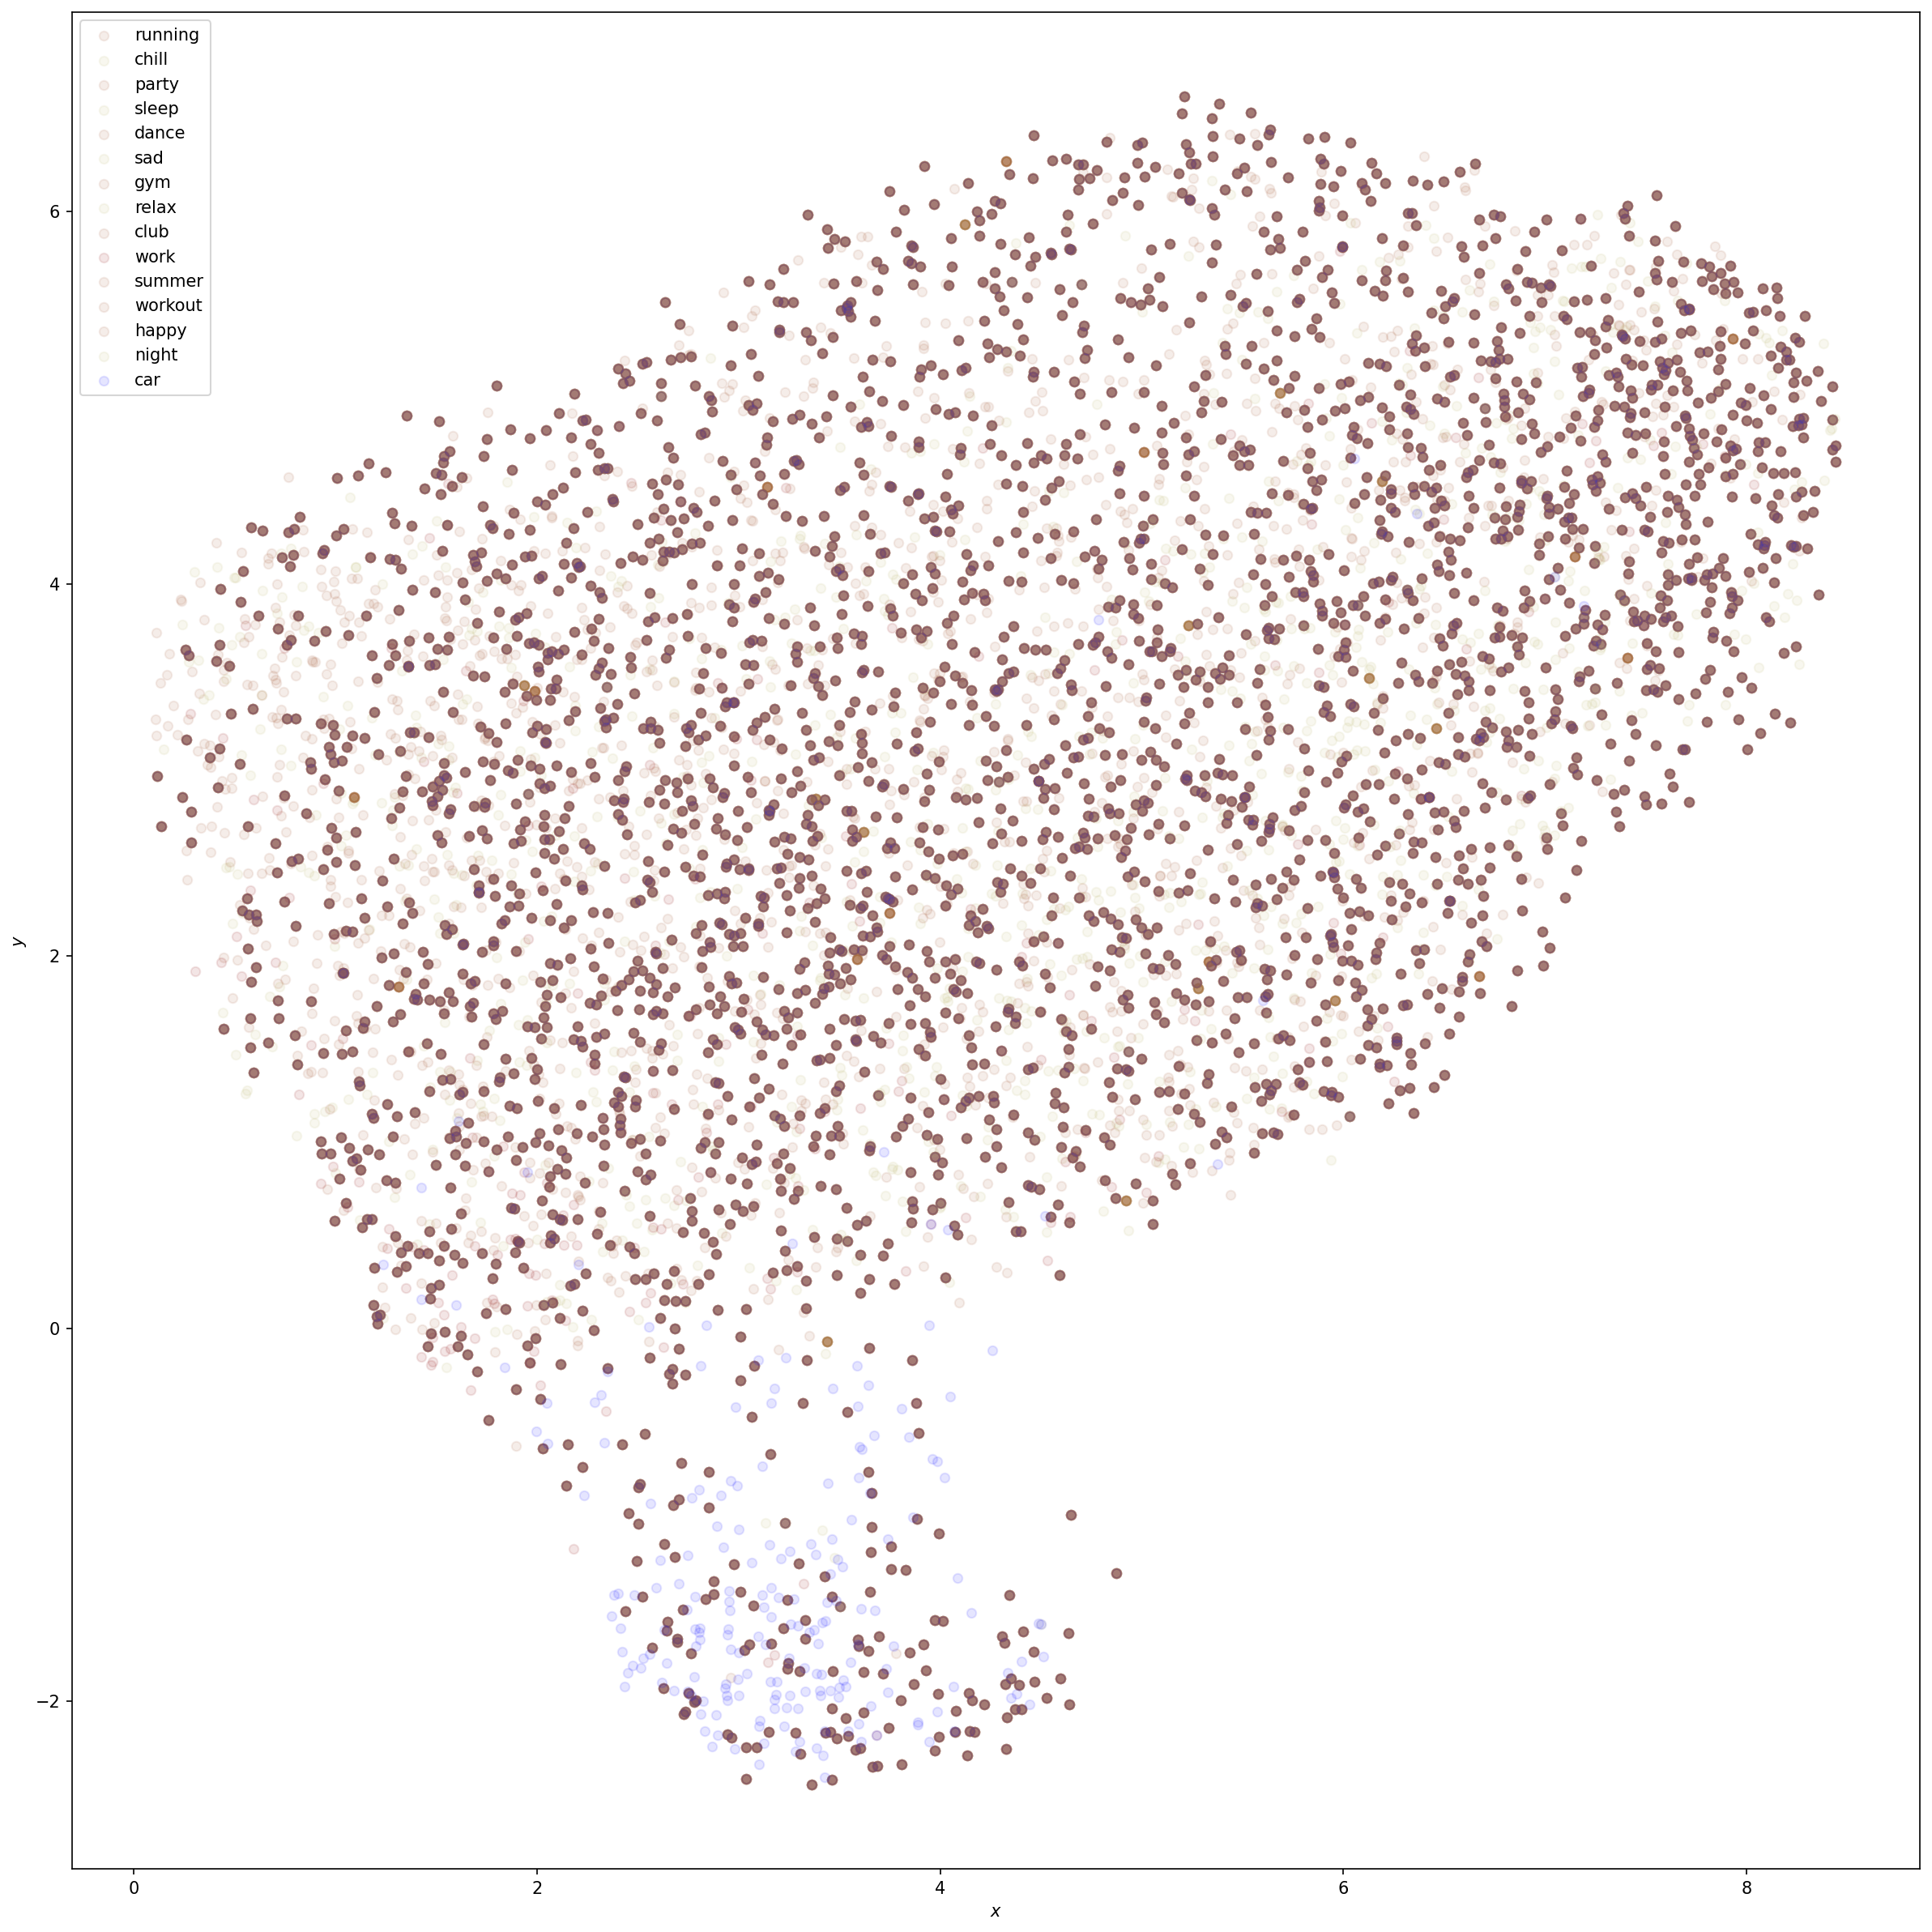

In [115]:
speech_viz(df_viz)